# Advanced Alphalens concepts

You've learned the basics of using Alphalens. This lesson explores the following advanced Alphalens concepts:

1. Determining how far an alpha factor's predictive value stretches into the future.
2. Dealing with a common Alphalens error named MaxLossExceededError.
3. Grouping assets by sector, then analyzing each sector individually.
4. Writing group neutral strategies.

**All sections of this lesson will use the data produced by the Pipeline created in the following cell. Please run it.**

**Important note**: Until this lesson, we passed the output of `run_pipeline()` to `get_clean_factor_and_forward_returns()` without any changes. This was possible because the previous lessons' Pipelines only returned one column. This lesson's Pipeline returns two columns, which means we need to *specify the column* we're passing as factor data. Look for commented code near `get_clean_factor_and_forward_returns()` in the following cell to see how to do this.

In [7]:
from quantopian.pipeline.data import factset

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.filters import QTradableStocksUS
from alphalens.utils import get_clean_factor_and_forward_returns


def make_pipeline():

    net_income_moving_average = SimpleMovingAverage( # 1 year moving average of net income
        inputs=[factset.Fundamentals.net_inc_af], 
        window_length=252
    )
    
    market_cap_moving_average = SimpleMovingAverage( # 1 year moving average of market cap
        inputs=[factset.Fundamentals.mkt_val], 
        window_length=252
    )
    
    average_market_cap_per_net_income = (market_cap_moving_average / net_income_moving_average)
    
    net_income = factset.Fundamentals.net_inc_qf.latest # the last quarter's net income
    
    projected_market_cap = average_market_cap_per_net_income * net_income

    sector = Sector()
    
    return Pipeline(
        columns = {
            'projected_market_cap': projected_market_cap,
            'sector': sector
        },
        screen = QTradableStocksUS() & projected_market_cap.notnull() & sector.notnull()
    )


factor_data = run_pipeline(make_pipeline(), '2013-1-1', '2014-1-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2013-1-1', '2014-3-1', fields='open_price')


merged_data = get_clean_factor_and_forward_returns(
    factor_data['projected_market_cap'], # This is how you analyze a specific pipeline column with Alphalens
    pricing_data, 
    periods=range(1,32,3)
)

Dropped 4.6% entries from factor data: 4.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Visualizing an alpha factor's decary rate

A lot of [fundamental data](link) only comes out 4 times a year in quarterly reports. Because of this low frequency, it can be useful to increase the amount of time `get_clean_factor_and_forward_returns()` looks into the future to calculate returns. 

**Tip:** A month usually has 21 trading days, a quarter usually has 63 trading days, and a year usually has 252 trading days.

Let's say you're creating a strategy that buys stock in companies with rising profits (data that is released every 63 trading days). Would you only look 10 days into the future to analyze that factor? Probably not! But how do you decide how far to look forward?

**Run the following cell to chart our alpha factor's IC mean over time. The point where the line dips below 0 represents when our alpha factor's predictions stop being useful.**

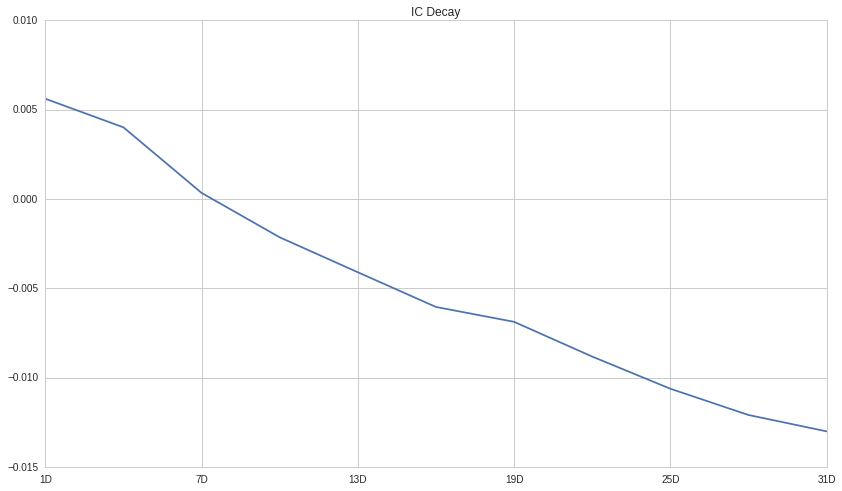

In [8]:
from alphalens.performance import mean_information_coefficient
mean_information_coefficient(merged_data).plot(title="IC Decay");

What do you think the chart will look like if we calculate the IC a full year into the future?

*Hint*: This is a setup for section two of this lesson.

In [9]:
merged_data = get_clean_factor_and_forward_returns(
    factor_data['projected_market_cap'], 
    pricing_data,
    periods=range(1,252,20) # The third argument to the range statement changes the "step" of the range
)

mean_information_coefficient(merged_data).plot()

Dropped 88.4% entries from factor data: 88.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).


MaxLossExceededError: max_loss (35.0%) exceeded 88.4%, consider increasing it.

## 2. Dealing with MaxLossExceededError

Oh no! What does `MaxLossExceededError` mean?

`get_clean_factor_and_forward_returns()` looks at how alpha factor data affects pricing data *in the future*. This means we need our pricing data to go further into the future than our alpha factor data **by at least as long as our forward looking period.** 

In this case, we'll change `get_pricing()`'s `end_date` to be at least a year after `run_pipeline()`'s `end_date`.

**Run the following cell to make those changes. As you can see, this alpha factor's IC decays quickly after a few days, but comes back even stronger than before six months into the future. Interesting!**

Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


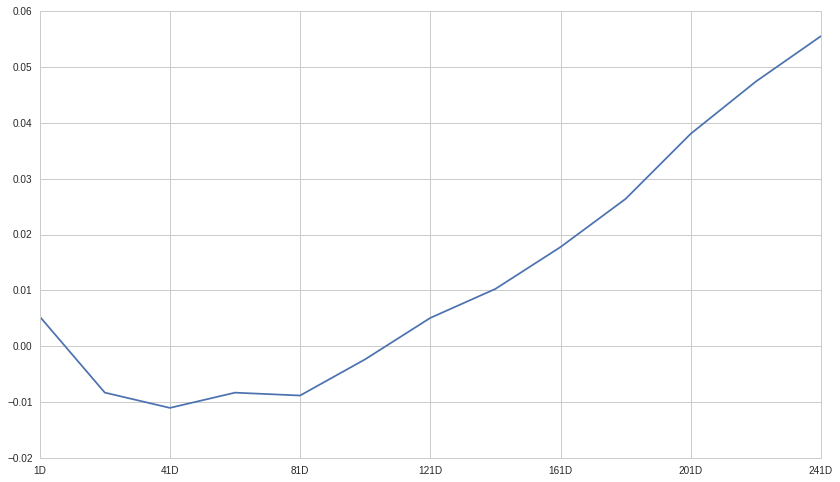

In [10]:
factor_data = run_pipeline(
    make_pipeline(),
    start_date='2013-1-1', 
    end_date='2014-1-1' #  *** NOTE *** Our factor data ends in 2014
)

pricing_data = get_pricing(
    factor_data.index.levels[1], 
    start_date='2013-1-1',
    end_date='2015-2-1', # *** NOTE *** Our pricing data ends in 2015
    fields='open_price'
)

merged_data = get_clean_factor_and_forward_returns(
    factor_data['projected_market_cap'], 
    pricing_data,
    periods=range(1,252,20) # Change the step to 10 or more for long look forward periods to save time
)

mean_information_coefficient(merged_data).plot()

*Note: MaxLossExceededError has two possible causes; forward returns computation and binning. We showed you how to fix forward returns computation here because it is much more common. You can read more about what binning is in the [API docs](link).*

## 3. Analyzing alpha factors by group

Alphalens allows you to group assets using a [classifier](link). A common use case for this is creating a classifier that specifies which sector each equity belongs to, then comparing your alpha factor's returns among sectors.

You can group assets by any classifier, but sector is most common. The Pipeline in the first cell of this lesson returns a column named `sector`, whose values represent the corresponding Morningstar sector code. All we have to do now is pass that column to the `groupby` argument of `get_clean_factor_and_forward_returns()`

**Run the following cell, and notice the charts at the bottom of the tear sheet showing how our factor performs in different sectors.**

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,-0.020,-0.016,-0.025
beta,-0.170,-0.171,-0.132
Mean Period Wise Return Top Quantile (bps),-1.163,-1.315,-1.391
Mean Period Wise Return Bottom Quantile (bps),0.649,1.366,1.930
Mean Period Wise Spread (bps),-1.778,-2.626,-3.246


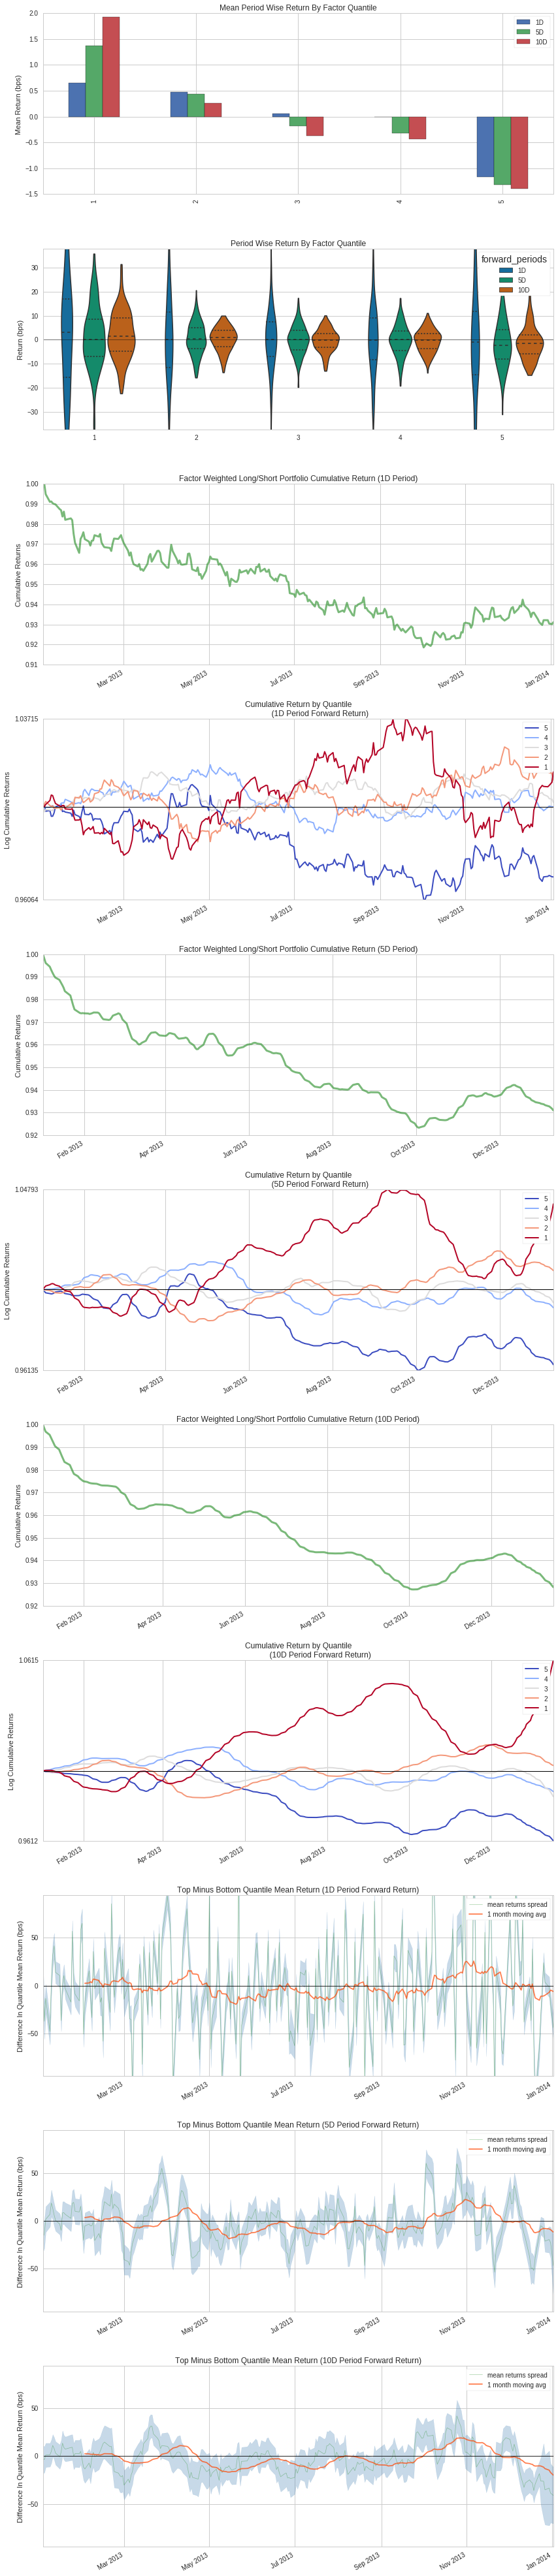

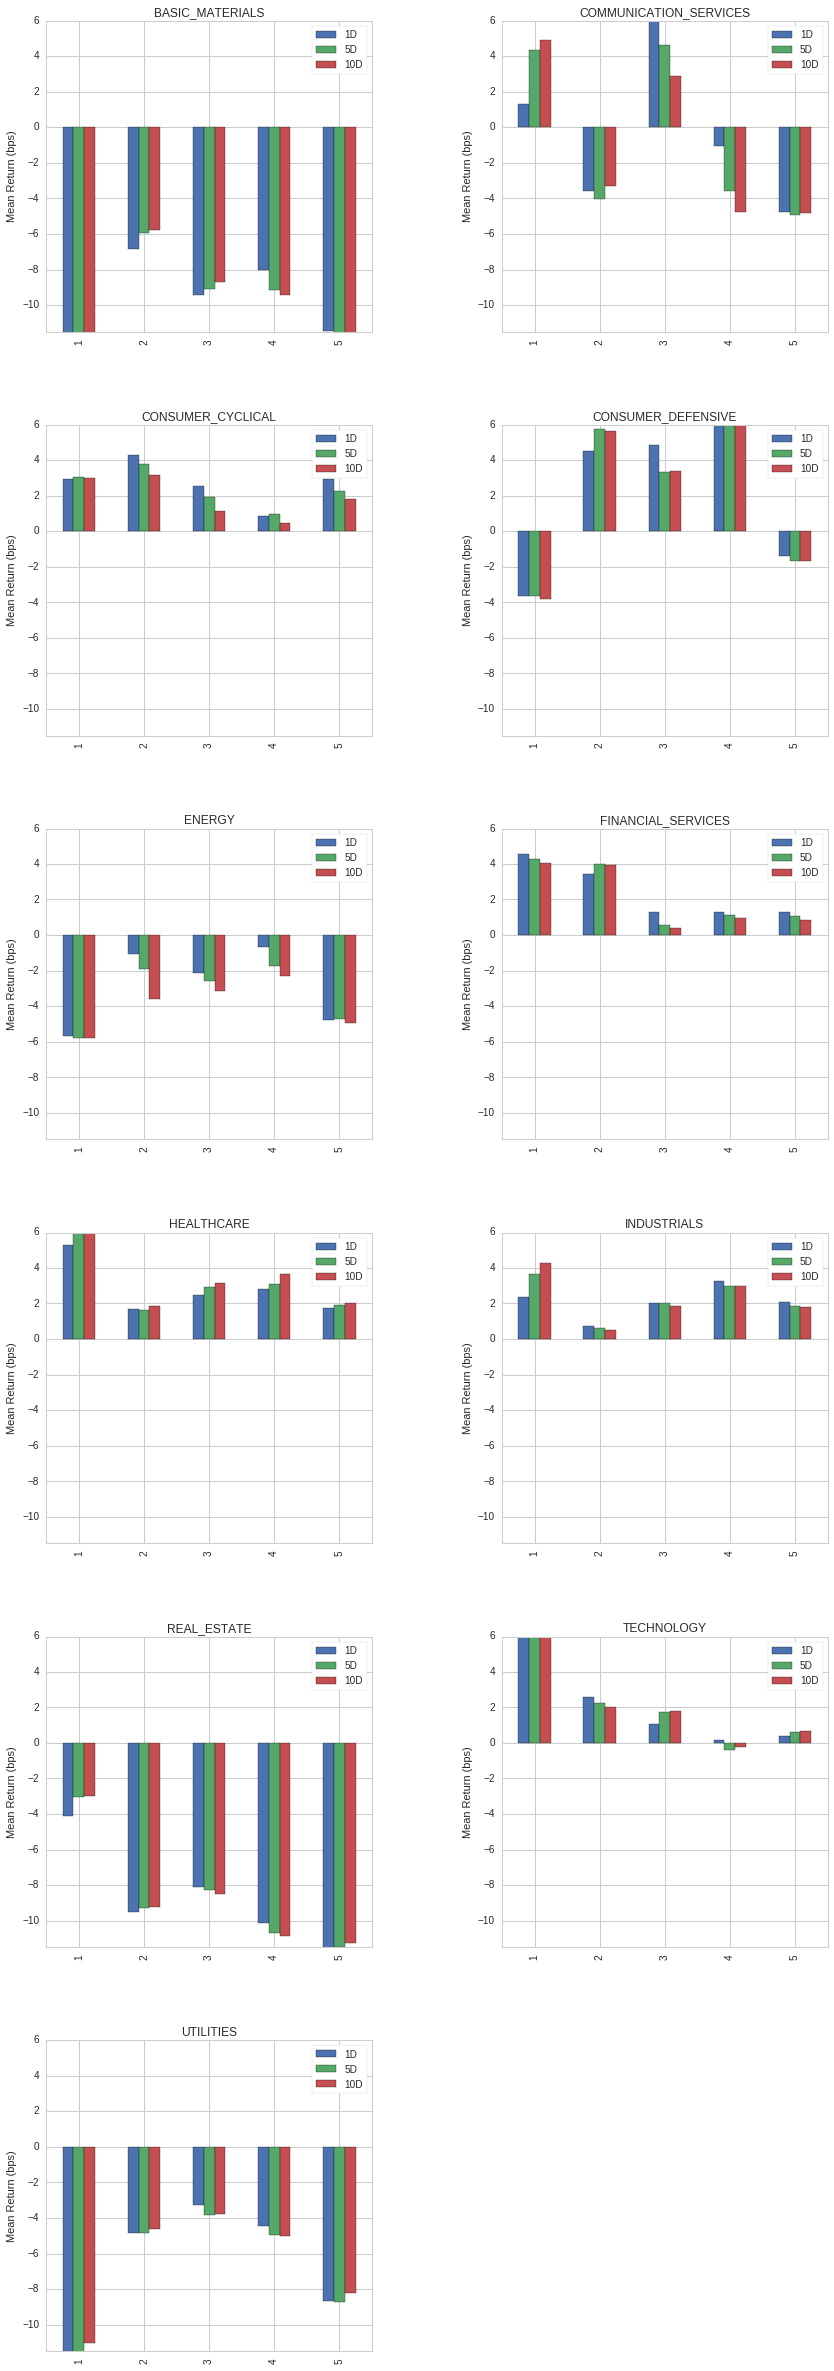

In [5]:
from alphalens.tears import create_returns_tear_sheet

sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

result = get_clean_factor_and_forward_returns(
    factor=factor_data['projected_market_cap'],
    prices=pricing_data,
    groupby=factor_data['sector'],
    groupby_labels=sector_labels,
)

create_returns_tear_sheet(factor_data=result, by_group=True) # Step 5

## 4. Writing group neutral strategies

Not only does Alphalens allow us to simulate how our alpha factor would perform in a long/short trading strategy, it also allows us to simulate how it would do if we went long/short on every group! 

Grouping by sector, and going long/short on each sector allows you to limit exposure to the overall movement of sectors. For example, you may have noticed in step three of this tutorial, that certain sectors had all positive returns, or all negative returns. That information isn't useful to us, because that just means the sector group outperformed (or underperformed) the market; it doesn't give us any insight into how our factor performs within that sector.

Since we grouped our assets by sector in the previous cell, going group neutral is easy; just make the two following changes:
- Pass `binning_by_group=True` as an argument to `get_clean_factor_and_forward_returns()`.
- Pass `group_neutral=True` as an argument to `create_full_tear_sheet()`.

**The following cell has made the approriate changes. Try running it and notice how the results differ from the previous cell.**

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.053,0.005,-0.001
beta,-0.082,-0.071,-0.064
Mean Period Wise Return Top Quantile (bps),-1.565,-1.433,-1.482
Mean Period Wise Return Bottom Quantile (bps),0.661,0.931,1.148
Mean Period Wise Spread (bps),-2.214,-2.358,-2.629


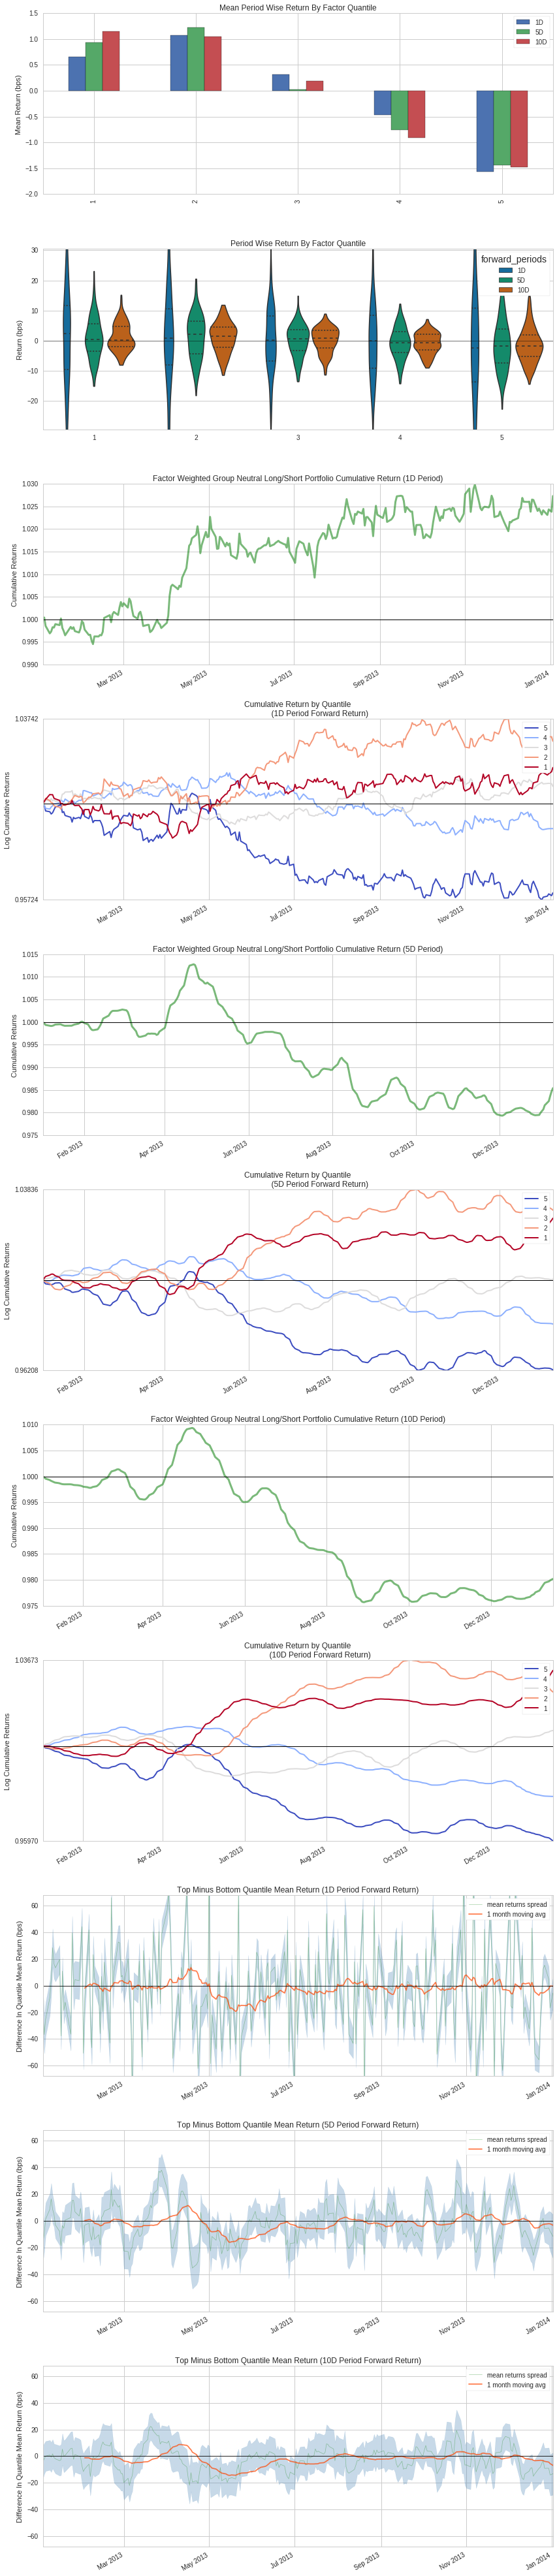

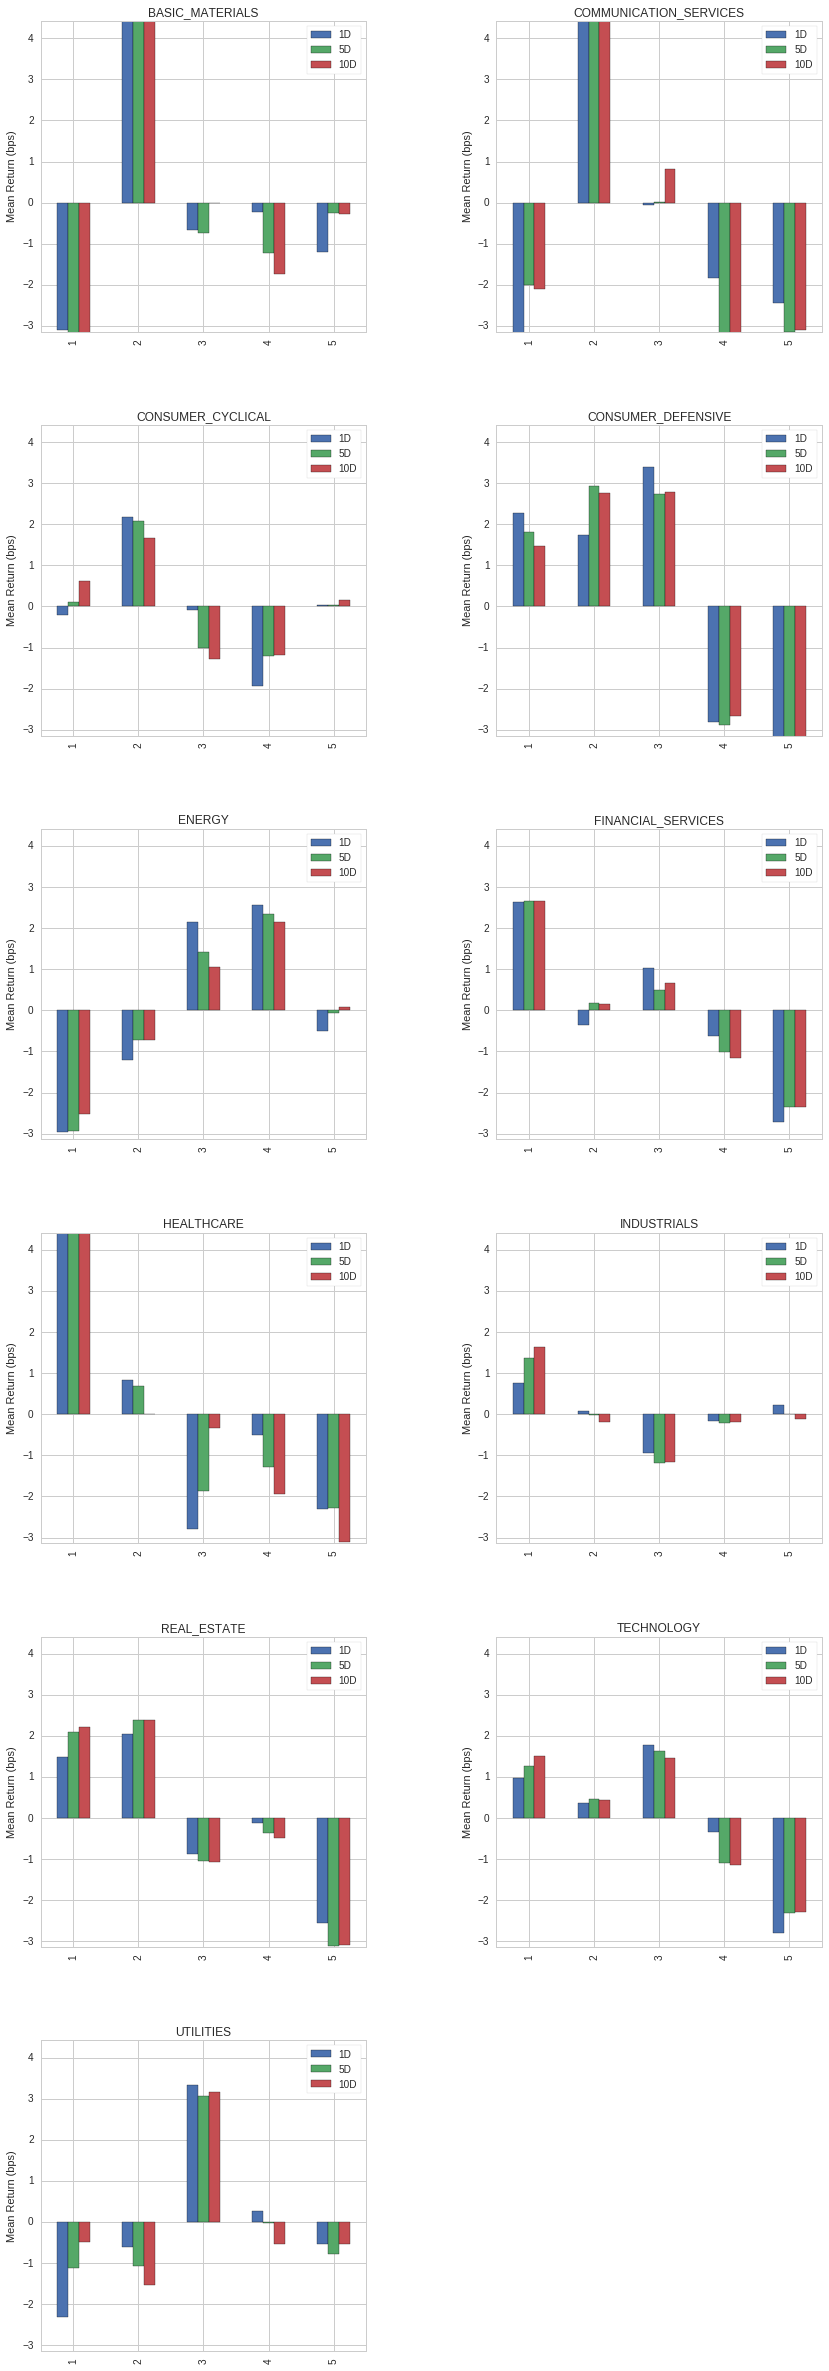

In [9]:
result = get_clean_factor_and_forward_returns(
    factor_data['projected_market_cap'],
    prices=pricing_data,
    groupby=factor_data['sector'],
    groupby_labels=sector_labels,
    binning_by_group=True,
)

create_returns_tear_sheet(result, by_group=True, group_neutral=True) # Step 5

That's it! This tutorial got you started with Alphalens, but there's so much more to it. Check out our [API docs](link) to see the rest!